/Users/Home/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Series([], dtype: float64)
Splitting data into prediction values (X) and target values (y) . . .


Dummy Classifier Most Frequent ROC AUC Score:  0.5
K Neighbors Classifier Fit
K Neighbors Classifier ROC AUC Score: 0.671568574505
K Neighbors Classifier completed in:  27 minutes, and 36.97 seconds
K Neighbors Classifier Best Params:  {'knn__n_neighbors': 100}
K Neighbors Classifier test data predictions have been saved.

Logistic Regression Fit
Logistic Regression ROC AUC Score: 0.692953018987
Logistic Regression completed in:  1 minutes, and 3.61 seconds
Logistic Regression Best Params:  {'logreg__C': 0.025, 'logreg__penalty': 'l1'}
Logistic Regression test data predictions have been saved.

Decision Tree Classifier Fit
Decision Tree Classifier ROC AUC Score: 0.679780903389
Decision Tree Classifier completed in:  7 minutes, and 31.61 seconds
Decision Tree Classifier best parameterss:  {'dtclf__max_depth': 7, 'dtclf__max_features': 17, 'dtclf__min_samples_split': 42}
Decision Tree Class

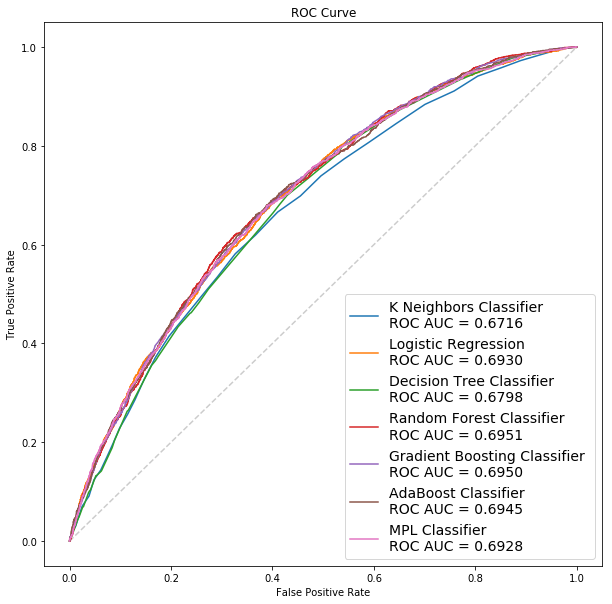

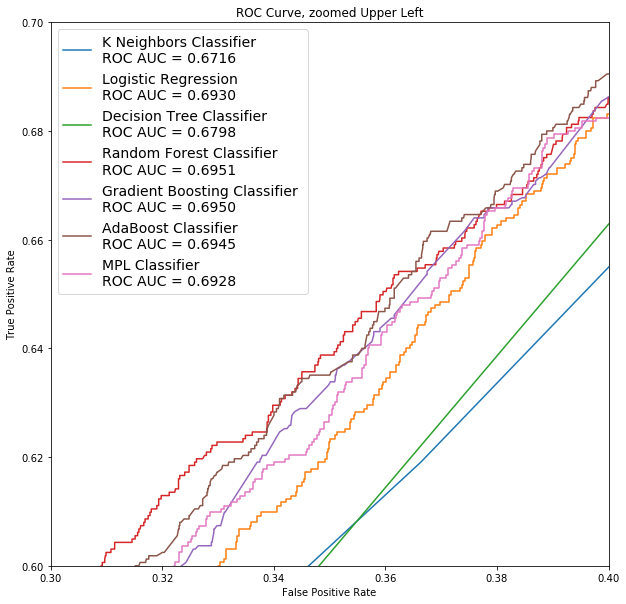

Total Script Runtime:  176 minutes, and 47.36 seconds.


In [11]:
# Tim Sturges
# License: I'm new to this. Whatever
# 
# Leaving college, my first full-time job was as a loan officer. I would receive requests for loans and screen 
# potential clients for their creditworthiness, according to learned criteria. When I learned the borrower data 
# for Lending Club was publicly available, it struck me immediately as something for which I might have some insight.
# As it turns out, it has been publicly available for sometime, and there is a concluded Kaggle competition using
# earlier data: 
#
# https://www.kaggle.com/c/predicting-loan-default
#
# While conducting this research, I initially found this analysis particularly helpful: 
#
# http://kldavenport.com/lending-club-data-analysis-revisted-with-python/
#
# Acknowledgements: Besides those listed above, all of the authors of the libraries without which none of this 
# would be possible. Also, all those involved in the Coursera Applied Data Science Curriculum with UMICH, which forms
# the basis of knowledge in Data Science / Analysis in Python.
#
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
#
# Objective: To attempt to predict Lending Club Loan Default rates using machine learning with 
# Python's sklearn library. 
# Estimator perfomance will be determined by attempting to maximize the Area Under the Curve (AUC) 
# of the Receiver Operator Characteristics (ROC).
# This is a calculation taking definite integral of a plot of the True Positive Rate (TPR) as a function of the
# False Positive Rate (FPR) on the interval [0,1], for all possbile classification thresholds. 
# ROC AUC is an excellent summary statistic for determining the effectiveness of a classifier, since it encompasses
# both the TPR (aka sensitivity or recall) and the FPR (or fall-out rate).
# More can be learned about ROC AUC Scoring here:
#
# https://en.wikipedia.org/wiki/Receiver_operating_characteristic
#
# Randomly guessing is expected to produce 0.5, so scores below this benchmark are worse than chance.
# Scores between 0.6 and 0.7 are generally considered poor, while scores between 0.7 and 0.8 are considered fair.
# Note that the Leaderboard tab of the aforementioned Kaggle competition has a best score of 0.718.
# The highest score I was able to achieve (using later data than ) was the Random Forest model at 0.6951, 
# which would be about position #41. Logistic Regression, however, proved to be a much more efficient model.
#
# # # # # # # # # # # # # # # # # # # # # # # # 
#
# Conclusion: I was unable to fit a machine learning model which was better than anything else published. 
# I learned a lot in the process of writing this analysis, and if I hadn't given myself a deadline, would continue
# refining the script, but for the moment I'm content to solicit criticism while I move onto another project.




# For the moment this analysis is confined to 2017 1st quarter data. Depending on performance, I may extend 
#the analysis to older data, but in theory the approach to analysis will be more or less the same regardless 
# of how much data is available.

# import necesary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import time

from datetime import datetime
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
#from sklearn.svm import SVC
#from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

%matplotlib inline

# acquiring the data
# data: https://www.lendingclub.com/info/download-data.action
# codebook: https://resources.lendingclub.com/LCDataDictionary.xlsx
# LoanStats2017Q1.csv
# LoanStats2017Q2.csv


#################################
# Cleaning and loading the data #
#################################
t0 = time.time()
df2017Q1 = pd.read_csv('LoanStats2017Q1.csv',header=1)

# Dropping columns and rows which are all Null / NaN.
# We're dropping NaN columns first, then columns which we determine to be of unneeded, or which can leak data
# into the classifiers.
# NaN rows are dropped last, because some rows may not be all NaN until after some needless columns are dropped.
df2017Q1 = df2017Q1.dropna(axis=1,how='all')

# dropping variables with obviously no predictive value, which an id # has not
# also noticed that I couldn't get rows of NaNs to drop, it turns out because the id# existed and nothing else
df2017Q1.drop('id',1, inplace=True)

# loan_amnt, funded_amnt, funded_amnt_inv. Surely we don't need all three? How often do these differ?
# I've decided to drop 'funded_amnt' and 'funded_amnt_inv'
# my reasoning: these highly are highly correlated, over 90%, therefore one is sufficient for predictive purposes
# why loan_amnt: it seems to be the most straightforward, and the dictionary claims the adjustments to the loan
# amount are reflected in loan_amnt
df2017Q1.drop('funded_amnt',1, inplace=True)
df2017Q1.drop('funded_amnt_inv',1, inplace=True)

# I intended to drop na rows later, but kept running into one-hot encoding problems later
# This may need to be done again later after other columns are dropped
df2017Q1 = df2017Q1.dropna(axis=0,how='all')

# moving code from later to this point, because I later ran into multiple columns with 29 NaNs 
# and imputation did not seem appropriate
df2017Q1.dropna(axis=0,subset=['inq_last_6mths'], inplace=True)
df2017Q1.reindex()

# term, int_rate, installment, grade, sub_grade. All of these are potentially useful
# term: 2 vals: 36 months or 60 months. term will be converted to float 36/60
# first I need a dictionary of replacement values
termdict = {'term': {' 36 months': 36, ' 60 months': 60}}
# now replace! 
df2017Q1.replace(termdict, inplace=True)

#int_rate: string type needs to be converted to float
df2017Q1['int_rate'].replace([' ','%'],['',''],regex=True,inplace=True)
df2017Q1['int_rate'] = df2017Q1['int_rate'].astype('float') / 100

# installment: already float; appears clean, however no predictive value, and highly (>.93) correlated with other data
# grade, sub_grade: they are clean but should these categorical vars be conveted to numeric?
# I've confirmed that sub_grade is a more specific version of grade, meaning at least grade can be dropped
# sub_grade will be OneHotEncoded using get_dummies to be usable in a variety of ML algos
df2017Q1.drop(['grade','installment'],1, inplace=True)

# one-hot encoding the easy way with get_dummies()
sub_grade_1he = pd.get_dummies(df2017Q1['sub_grade'],prefix='sub_grade')

# Highly doubtful that the emp_title will be useful for our purposes, so it is dropped
df2017Q1.drop('emp_title',1, inplace=True)

# emp_length, home_ownership, annual_inc, verification_status, issue_d
# I have been taught these variables (except issue_d) are valuable indicators of credit worthiness. we shall see
# emp_leng: convert to numeric
df2017Q1['emp_length'].replace('n/a', np.nan,inplace=True)
df2017Q1['emp_length'].fillna(value=0,inplace=True)
df2017Q1['emp_length'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
df2017Q1['emp_length'] = df2017Q1['emp_length'].astype(float)

# home_ownership: convert to categorical with One Hot Encoding (1he)
home_ownership_1he = pd.get_dummies(df2017Q1['home_ownership'],prefix='home_ownership')

# annual_inc: 4 NaNs; fillwith 0
df2017Q1['annual_inc'].fillna(value=0.0,inplace=True)

# verification_status: convert to categorical: 1he
verification_status_1he = pd.get_dummies(df2017Q1['verification_status'],prefix='verification_status')

# issue_d: dropped for low predictive value
df2017Q1.drop('issue_d',1, inplace=True)

# Next five vars: loan_status, pymnt_plan, desc, purpose, title
# loan_status: what we're attempting to predict; 1he
df2017Q1['loan_status'].replace('Does not meet the credit policy. Status:', '',regex=True,inplace=True)
loan_status_1he = pd.get_dummies(df2017Q1['loan_status'])

#pymnt_plan: I'm hoping this is not a measure to address delinquency; all 'n' = zero predictive value; dropped
df2017Q1.drop('pymnt_plan',1, inplace=True)

# I imagine something in the following three vars [desc, purpose, title] could have predictive power fundamentally, 
# desc: apparently user-defined. verbose, unusable (or ill-advised) IMO

# purpose: although topically redundant, this is potentially useful for ML, some clearly defined categories
# I've decided to 1he this variable 
purpose_1he = pd.get_dummies(df2017Q1['purpose'],prefix='purpose')

# title: somewhere in between desc and purpose in its granularity
df2017Q1.drop(['desc','title'],1, inplace=True)


# Next five vars: zip_code, addr_state, dti, delinq_2yrs, earliest_cr_line
# zip_code: They all suffixed xx. Do they correlate highly with addr_state? The whole ZIP, which we do not have
# might have predictive value; I'm guessing that the state has little if any
df2017Q1.drop(['zip_code','addr_state'],1, inplace=True)

# dti: debt-to-income ratio, at least as I learned it, was the ratio of monthly expenses to monthly income
# as reported on a potential borrowers credit report. Although it's worth noticing that the three credit bureaus 
# will receive and process this information from creditors at different times, meaning that the three bureau's reports
# rarely agree, but regardless we need some idea of how much of their monthly income people were spending. Above 40%
# was considered bad, except for people who had high credit scores; above 50% was bad regardless of your credit rating
# DTI will likely have strong predictive value, or so I hope
# this will be converted to a percentage; normally I would represent it is a decimal proportion of 1, but 
# I believe for ML it will not matter

# delinq_2yrs: number of 30+ days past due notices in the previous 2 years. Recent delinquencies are not something
# we want in prospective borrowsers. 
# shockingly, this feature ALSO seems not to need any preprocessing


# earliest_cr_line: length of credit history; seemed potentially useful at first, but did not.
# convert to datetime -- and to a scalar to measure length of time since now
# Note: the following is essentially identical to Kevin Davenport's example (see header)
# df2017Q1['earliest_cr_line'] = pd.to_datetime(df2017Q1['earliest_cr_line'])
# dttoday = datetime.now().strftime('%Y-%m-%d')
# df2017Q1['earliest_cr_line'] = df2017Q1['earliest_cr_line'].apply(
#     lambda x: (np.timedelta64((x - pd.Timestamp(dttoday)),'D').astype(int))/-365)
df2017Q1.drop(['earliest_cr_line'],1, inplace=True)

# Next five: inq_last_6mths, mths_since_last_delinq, mths_since_last_record, open_acc, pub_rec
# inq_last_6mths: 29 NaNs, which coincide with NaNs in other columns; we can manage without these 29
# however, because of the dummy encodings earlier, we need to do this before those encodings, and also reindex
# the below commented line is copied above, where rows of NaNs were removed; and the data frame reindexed
#df2017Q1.dropna(axis=0,subset=['inq_last_6mths'], inplace=True)

# mths_since_last_delinq, mths_since_last_record: here the NaNs could mean never
# If I knew this were the case, I could replace with the length of credit history, however then it would be highly
# corrlated with other data (itself). Therefore these will be dropped
df2017Q1.drop(['mths_since_last_delinq', 'mths_since_last_record'],1, inplace=True)

# inq_last_6mths: how many credit inquires in the previous 6 months. a high number would be alarming
# this feature appears clean

# open_acc: number of open credit lines. generally we'd like to see more than none and fewer than many
# this feature appears clean

# pub_rec: number of derogatory public records. we'd like to see lots of 0s in this column
# feature appears clean

# Next five: revol_bal, revol_util, total_acc, initial_list_status, out_prncp
# revol_bal: total credit revolving balance, unsecured debt, typically credit cards, but also HELOCs and such
# feature appears clean
# dropping total accounts due to high correlations discovered later
df2017Q1.drop('total_acc',1, inplace=True)

# revol_util: percentage of total obligation across all revolving credit lines
# first need to convert from string, then need to impute missing vals
#print(df2017Q1['revol_util'].isnull().any())
df2017Q1['revol_util'].replace([' ','%'],['',''],regex=True,inplace=True)
df2017Q1['revol_util'] = df2017Q1['revol_util'].astype('float') / 100
#revol_util_mean = np.mean(df2017Q1['revol_util'])
df2017Q1['revol_util'].fillna(value=np.mean(df2017Q1['revol_util']), inplace=True)

# total_acc: total number of accounts in credit line
# feature appears clean

# initial_list_status: codebook is little help here; irrelevant since there is no variance; dropped
# out_prncp: zero variance; dropped
df2017Q1.drop(['initial_list_status','out_prncp'],1, inplace=True)

# Next five: out_prncp_inv, total_pymnt, total_pymnt_inv, total_rec_prncp, total_rec_int
# out_prncp_inv: delete; all zeros
# total_pymnt, total_pymnt_inv: payments received to date, and paid to investors
# total_rec_prncp, total_rec_int: principle and interest received to date
# these are features which would be unavailable to me were I attempting to predict creditworthiness
# they will be removed to avoid data leakage
df2017Q1.drop(['out_prncp_inv','total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int'],1, inplace=True)

# Next five: total_rec_late_fee, recoveries, collection_recovery_fee, last_pymnt_d, last_pymnt_amnt
# total_rec_late_fee: remove because of data leakage
# recoveries: emove because of data leakage
# collection_recovery_fee. no apparent predictive value; drop; also leaky
# last_pymnt_d: I see no predictive value here
df2017Q1.drop(['total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_d','last_pymnt_amnt'],
              1, inplace=True)

# Next Five: ['next_pymnt_d',last_credit_pull_d,collections_12_mths_ex_med,'policy_code','application_type'
# next_pymnt_d: next scheduled payment date: leaky data
# last_credit_pull_d: most recent LC pull of credit report; hard to imagine predictive value, possibly leaky
# collections_12_mths_ex_med: number of non-medical collections in past 12 months; drop for 0 variance
# policy_code: drop for 0 variance
# application_type: drop for 0 variance
df2017Q1.drop(['next_pymnt_d','last_credit_pull_d','collections_12_mths_ex_med','policy_code','application_type']
              ,1, inplace=True)

# Next five ['acc_now_delinq','chargeoff_within_12_mths','delinq_amnt','pub_rec_bankruptcies','tax_liens']
# acc_now_delinq: accounts now delinquent; drop bc 0 variance, potentially leaky
# chargeoff_within_12_mths: drop bc 0 variance, potentially leaky
# delinq_amnt: amount past due on all delinquent accounts. not much here, probably not much predictive value; drop
# pub_rec_bankruptcies: number of public record bankrupcies; keep; fillna with mean
#df2017Q1['pub_rec_bankruptcies'].fillna(value=np.mean(df2017Q1['pub_rec_bankruptcies']), inplace=True)
##on second thought, I learn later that this is correlating highly with other data, and so it is being dropped
df2017Q1.drop('pub_rec_bankruptcies',1, inplace=True)

# tax_liens: number of tax liens. near 0 variance; dropped
df2017Q1.drop(['acc_now_delinq','chargeoff_within_12_mths','delinq_amnt','tax_liens'],1, inplace=True)

# Next five: ['hardship_flag','disbursement_method','debt_settlement_flag','debt_settlement_flag_date',
# 'settlement_status']
# last four: ['settlement_date','settlement_amount','settlement_percentage','settlement_term']
# hardship_flag: drop bc 0 variance
# disbursement_method: drop bc 0 variance
# debt_settlement_flag: this and the remaining vars will all be droppped because they are leaky data
# debt_settlement_flag_date: 
# settlement_status: 3 vals: 
# settlement_date: 
# settlement_amount: 
# settlement_percentage: 
# settlement_term: 
df2017Q1.drop(['hardship_flag','disbursement_method','debt_settlement_flag','debt_settlement_flag_date',
              'settlement_status','settlement_date','settlement_amount','settlement_percentage',
               'settlement_term'],1, inplace=True)

#print(df2017Q1['settlement_status'].isnull().any())
#print(df2017Q1['settlement_status'].isnull().value_counts())
#print(df2017Q1['settlement_status'].value_counts())
#print('var:',np.var(df2017Q1['tax_liens']))
#print(df2017Q1['settlement_status'].describe())

# last four!: ['settlement_date','settlement_amount','settlement_percentage','settlement_term']

#print('\n'.join(list(df2017Q1.columns)))

# Let's get an idea from the correlation matrix regarding the highly correlated variables
# Many analyses choose a seemingly arbitrary cutoff level for correlation (e.g. >= 0.65 | 0.80)
# I'm going to look at the distribution of correlations first to see if there 

#corrdf2017Q1 = df2017Q1.corr()
#corrdf2017Q1.loc[:,:] = np.tril(corrdf2017Q1,k=-1)
#corrdf2017Q1 = corrdf2017Q1.stack()
#print(corrdf2017Q1[np.absolute(corrdf2017Q1 > 0.55)])


#[print(x,type(df2017Q1.ix[0,x])) for x in df2017Q1.columns]

#######################################################################
#                                                                     #
#                Pre-processing and Model-Building                    #
#                                                                     #
#######################################################################

# creating new clean data frame with numeric features; object types were categorical which were one-hot encoded
df2017Q1_clean = df2017Q1.select_dtypes(include=['float64','int64'],exclude=['object'])

# I want a list of the numeric vars which were not one-hot-encoded (non-categorical) so that I can standardize 
# them leaving the one-hot-encodings untouched (standardization not necessary)
df2017Q1_numcol_idx = df2017Q1_clean.columns

# first I want to examine my clean data set for highly correlated data
df2017Q1_clean = pd.concat([df2017Q1_clean,sub_grade_1he,home_ownership_1he,
                            verification_status_1he,loan_status_1he],axis=1,join_axes=[df2017Q1_clean.index])

# "Fully Paid" will not be included anyway since it's the opposite of "Charged Off"
# "Rent" and "Mortgage" are strongly negatively correlated, however I am disinclined to remove them
# "Total" and "Open" accounts are strongly correlated, but also think they may be relevant
# "Pub Rec" and "mths_since..." are highly correlated, but could be valuable
# Verification Status are highly correlated, but I'm curious as to why they aren't MORE highly correlated
# I'm leaving these as they are just above the threshold
# Rent vs Mortgage are highly correlated, so I'm removing one (rent) since there isn't much inbetween

df2017Q1_clean.drop(['Fully Paid','home_ownership_RENT','verification_status_Verified'],1, inplace=True)

##################################
# Viewing the correlation matrix #
##################################
# dfcorr = df2017Q1_clean.corr()
# dfcorr.iloc[:,:] = np.tril(dfcorr,k=-1)
# print(dfcorr[(dfcorr > .6) | (dfcorr < -.6) ].stack())



# split the data into prediction and target data
print('Splitting data into prediction values (X) and target values (y) . . .\n\n')
X, y = df2017Q1_clean.iloc[:,:-1], df2017Q1_clean.iloc[:,-1]

# splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# setting up a stratified K-fold structure for cross-val
stratkfold = StratifiedKFold(n_splits=3,shuffle=False, random_state=0)

# Preparing a DummyClassifier for a baseline ROC AUC score
# This is a formality; by definition the most_frequent stragegy will produce AUC of 0.5
# This is to say: the True Positive and False Positive rates will both be 100%
# 
dummy_mf = DummyClassifier(strategy='most_frequent',random_state=0)
dummy_mf.fit(X_train, y_train)
proba_dummy_mf = dummy_mf.predict_proba(X_test)[:,1]
print('Dummy Classifier Most Frequent ROC AUC Score: ',roc_auc_score(y_test,proba_dummy_mf))

########################################################
# K Neighbors Classifer with Pipeline and GridSearchCV #
########################################################
#
steps_knn = [('standardize',StandardScaler()),
            ('knn',KNeighborsClassifier())]
pipe_knn = Pipeline(steps_knn)
cv_knn = GridSearchCV(pipe_knn,
                     param_grid={'knn__n_neighbors': [50, 100, 500]},
                     scoring='roc_auc',
                     cv=stratkfold,
                     refit='AUC')

t_knn0 = time.time()
print('K Neighbors Classifier Fit')
cv_knn.fit(X_train,y_train)
score_knn = cv_knn.score(X_test,y_test)
print('K Neighbors Classifier ROC AUC Score:',score_knn)
t_knn1 = time.time()
print('K Neighbors Classifier completed in: ',
     int((t_knn1 - t_knn0) / 60),
     'minutes, and',
     round((t_knn1 - t_knn0) % 60,2),
     'seconds')
print('K Neighbors Classifier Best Params: ',cv_knn.best_params_)
proba_knn = cv_knn.predict_proba(X_test)[:,1]
print('K Neighbors Classifier test data predictions have been saved.\n')
#################################
# K Neighbors Classifier Output #
#################################
#
# K Neighbors Classifier ROC AUC Score: 0.671568574505
# K Neighbors Classifier completed in:  27 minutes, and 36.97 seconds
# K Neighbors Classifier Best Params:  {'knn__n_neighbors': 100}
#

################################################################
# Logistic Regression Classifer with Pipeline and GridSearchCV #
################################################################
#
steps_logreg = [('standardize',StandardScaler()),
             ('logreg',LogisticRegression(random_state=0,))]
pipe_logreg = Pipeline(steps_logreg)
cv_logreg = GridSearchCV(pipe_logreg,
                      param_grid={'logreg__C': [0.00001,0.001,.05,0.025,0.01,
                                                0.1,0.5,1,10,100,1000],
                                  'logreg__penalty': ['l1','l2']},
                      scoring='roc_auc',
                      cv=stratkfold,
                      refit='AUC')

t_logreg0 = time.time()
print('Logistic Regression Fit')
cv_logreg.fit(X_train,y_train)
score_logreg = cv_logreg.score(X_test,y_test)
print('Logistic Regression ROC AUC Score:',score_logreg)
t_logreg1 = time.time()
print('Logistic Regression completed in: ',
      int((t_logreg1 - t_logreg0) / 60),
      'minutes, and',
      round((t_logreg1 - t_logreg0) % 60,2),
      'seconds')
print('Logistic Regression Best Params: ',cv_logreg.best_params_)
proba_logreg = cv_logreg.predict_proba(X_test)[:,1]
print('Logistic Regression test data predictions have been saved.\n')
##############################
# Logistic Regression Output #
##############################
#
# Logistic Regression ROC AUC Score: 0.692953018987
# Logistic Regression completed in:  1 minutes, and 3.61 seconds
# Logistic Regression Best Params:  {'logreg__C': 0.025,
#                                    'logreg__penalty': 'l1'}
#Logistic Regression test data predictions have been saved.
#


# 6th ML algp: SVC: train: .872, test: .842
#svc = SVC(C=10).fit(X_train_scaled, y_train)
#print('SVC train score: ',svc.score(X_train_scaled,y_train))
#print('SVC Regression test score: ',svc.score(X_test_scaled,y_test))
##############
# the following code is unbearably slow; moving on to other algorithms
##############
#steps_svc = [('standardize',StandardScaler()),
#             ('svc',SVC(random_state=0,))]
#pipe_svc = Pipeline(steps_svc)
#cv_svc = GridSearchCV(pipe_svc,
#                      param_grid={'svc__C': [1]},
#                      scoring='roc_auc',
#                      cv=stratkfold,
#                      refit='AUC')#
#
#t_svc0 = time.time()
#print('SVC Fit')
#cv_svc.fit(X_train,y_train)
#print('SVC ROC AUC Score:',cv_svc.score(X_test,y_test))
#t_svc1 = time.time()
#print('SVC completed in: ',
#      int((t_svc1 - t_svc0) / 60),
#      'minutes, and',
#      round((t_svc1 - t_svc0) % 60,2),
#      'seconds')
#


################################################
# Decision Tree with Pipeline and GridSearchCV #
################################################
#
steps_dtclf = [('standardize',StandardScaler()),
            ('dtclf',DecisionTreeClassifier(random_state=0,))]
pipe_dtclf = Pipeline(steps_dtclf)
cv_dtclf = GridSearchCV(pipe_dtclf,
                       param_grid={
                           'dtclf__max_features' : range(1,20),
                           'dtclf__max_depth' : range(2,11),
                           'dtclf__min_samples_split' : range(2,52,10)
                       },
                       scoring='roc_auc',
                       cv=stratkfold,
                       refit='AUC'
                      )

t_dtclf0 = time.time()
print('Decision Tree Classifier Fit')
cv_dtclf.fit(X_train,y_train)
score_dtclf = cv_dtclf.score(X_test,y_test)
print('Decision Tree Classifier ROC AUC Score:',score_dtclf)
t_dtclf1 = time.time()
print('Decision Tree Classifier completed in: ',
     int((t_dtclf1 - t_dtclf0) / 60),
     'minutes, and',
     round((t_dtclf1 - t_dtclf0) % 60,2),
     'seconds')
print('Decision Tree Classifier best parameterss: ',cv_dtclf.best_params_)
proba_dtclf = cv_dtclf.predict_proba(X_test)[:,1]
print('Decision Tree Classifier test data predictions have been saved.\n')
#
###################################
# Decision Tree Classifier Output #
###################################
#
# Decision Tree Classifier ROC AUC Score: 0.679780903389
# Decision Tree Classifier completed in:  7 minutes, and 31.61 seconds
# Decision Tree Classifier best parameterss:  {'dtclf__max_depth': 7,
#                                              'dtclf__max_features': 17,
#                                              'dtclf__min_samples_split': 42}
#Decision Tree Classifier test data predictions have been saved.


###########################################################
# Random Forest Classifier with Pipeline and GridSearchCV #
###########################################################
#
steps_rfclf = [('standardize',StandardScaler()),
            ('rfclf',RandomForestClassifier(random_state=0,))]
pipe_rfclf = Pipeline(steps_rfclf)
cv_rfclf = GridSearchCV(pipe_rfclf,
                       param_grid={
                           'rfclf__n_estimators' : range(1,11),
                           'rfclf__max_features' : range(1,11),
                           'rfclf__max_depth' : range(2,11),
                           'rfclf__min_samples_split' : range(2,42,10)
                       },
                       scoring='roc_auc',
                       cv=stratkfold,
                       refit='AUC'
                      )

t_rfclf0 = time.time()
print('Random Forest Classifier Fit')
cv_rfclf.fit(X_train,y_train)
score_rfclf = cv_rfclf.score(X_test,y_test)
print('Random Forest Classifier ROC AUC Score:',score_rfclf)
t_rfclf1 = time.time()
print('Random Forest Classifier completed in: ',
     int((t_rfclf1 - t_rfclf0) / 60),
     'minutes, and',
     round((t_rfclf1 - t_rfclf0) % 60,2),
     'seconds')
print('Random Forest Classifier best parameterss: ',cv_rfclf.best_params_)
proba_rfclf = cv_rfclf.predict_proba(X_test)[:,1]
print('Random Forest Classifier test data predictions have been saved.\n')
###################################
# Random Forest Classifier Output #
###################################
#
# Random Forest Classifier ROC AUC Score: 0.695144121819
# Random Forest Classifier completed in:  50 minutes, and 49.0 seconds
# Random Forest Classifier best parameterss:  {'rfclf__n_estimators': 10,
#                                              'rfclf__max_depth': 8,
#                                              'rfclf__max_features': 8,
#                                              'rfclf__min_samples_split': 22}
#Random Forest Classifier test data predictions have been saved.


###############################################################
# Gradient Boosting Classifier with Pipeline and GridSearchCV #
###############################################################
#
steps_gbclf = [('standardize',StandardScaler()),
              ('gbclf',GradientBoostingClassifier(random_state=0,))]
pipe_gbclf = Pipeline(steps_gbclf)
cv_gbclf = GridSearchCV(pipe_gbclf,
                       param_grid={
                           'gbclf__learning_rate' : [.001,.01,.1,1],
                           'gbclf__n_estimators' : range(1,11),
                           'gbclf__max_depth' : range(1,9),
                           'gbclf__min_samples_split' : range(2,42,10)
                       },
                       scoring='roc_auc',
                       cv=stratkfold,
                       refit='AUC'
                      )

t_gbclf0 = time.time()
print('Gradient Boosting Classifier Fit')
cv_gbclf.fit(X_train,y_train)
score_gbclf = cv_gbclf.score(X_test,y_test)
print('Gradient Boosting Classifier ROC AUC Score:',score_gbclf)
t_gbclf1 = time.time()
print('Gradient Boosting Classifier completed in: ',
     int((t_gbclf1 - t_gbclf0) / 60),
     'minutes, and',
     round((t_gbclf1 - t_gbclf0) % 60,2),
     'seconds')
print('Gradient Boosting Classifier best parameterss: ',cv_gbclf.best_params_)
proba_gbclf = cv_gbclf.predict_proba(X_test)[:,1]
print('Gradient Boosting Classifier test data predictions have been saved.\n')
#######################################
# Gradient Boosting Classifier Output #
#######################################
#
# Gradient Boosting Classifier ROC AUC Score: 0.69500391366
# Gradient Boosting Classifier completed in:  70 minutes, and 32.06 seconds
# Gradient Boosting Classifier best parameterss:  {'gbclf__n_estimators': 10,
#                                                  'gbclf__learning_rate': 0.1,
#                                                  'gbclf__min_samples_split': 32,
#                                                  'gbclf__max_depth': 5}
#Gradient Boosting Classifier test data predictions have been saved.



######################################################
# AdaBoost Classifier with Pipeline and GridSearchCV #
######################################################
#
steps_abclf = [('standardize',StandardScaler()),
              ('abclf',AdaBoostClassifier(random_state=0,))]
pipe_abclf = Pipeline(steps_abclf)
cv_abclf = GridSearchCV(pipe_abclf,
                       param_grid={
                           'abclf__n_estimators' : range(1,51),
                           'abclf__learning_rate' : [.1,1,10]
                       },
                       scoring='roc_auc',
                       cv=stratkfold,
                       refit='AUC'
                      )

t_abclf0 = time.time()
print('AdaBoost Classifier Fit')
cv_abclf.fit(X_train,y_train)
score_abclf = cv_abclf.score(X_test,y_test)
print('AdaBoost Classifier ROC AUC Score:',score_abclf)
t_abclf1 = time.time()
print('AdaBoost Classifier completed in: ',
     int((t_abclf1 - t_abclf0) / 60),
     'minutes, and',
     round((t_abclf1 - t_abclf0) % 60,2),
     'seconds')
print('AdaBoost Classifier best parameterss: ',cv_abclf.best_params_)
proba_abclf = cv_abclf.predict_proba(X_test)[:,1]
print('AdaBoost Classifier test data predictions have been saved.\n')
##############################
# AdaBoost Classifier Output #
##############################
#
#AdaBoost Classifier ROC AUC Score: 0.694456172133
#AdaBoost Classifier completed in:  7 minutes, and 37.4 seconds
#AdaBoost Classifier best parameterss:  {'abclf__n_estimators': 42,
#                                        'abclf__learning_rate': 1}
#AdaBoost Classifier test data predictions have been saved.


#################################################
# MPL Classifier with Pipeline and GridSearchCV #
#################################################
#
steps_mplclf = [('standardize',StandardScaler()),
              ('mplclf',MLPClassifier(random_state=0,))]
pipe_mplclf = Pipeline(steps_mplclf)
cv_mplclf = GridSearchCV(pipe_mplclf,
                       param_grid={
                           'mplclf__hidden_layer_sizes' : [(10,),(25,),(50,),(75,),(100,)],
                           'mplclf__alpha' : [1e-4,1e-2,1e-1,1,5,10]
                       },
                       scoring='roc_auc',
                       cv=stratkfold,
                       refit='AUC'
                      )

t_mplclf0 = time.time()
print('MPL Classifier Fit')
cv_mplclf.fit(X_train,y_train)
score_mplclf = cv_mplclf.score(X_test,y_test)
print('MPL Classifier ROC AUC Score:',score_mplclf)
t_mplclf1 = time.time()
print('MPL Classifier completed in: ',
     int((t_mplclf1 - t_mplclf0) / 60),
     'minutes, and',
     round((t_mplclf1 - t_mplclf0) % 60,2),
     'seconds')
print('MPL Classifier best parameterss: ',cv_mplclf.best_params_)
proba_mplclf = cv_mplclf.predict_proba(X_test)[:,1]
print('MPL Classifier test data predictions have been saved.\n')
#########################
# MPL Classifier Output #
#########################
#
# MPL Classifier ROC AUC Score: 0.692839334849
# MPL Classifier completed in:  9 minutes, and 58.29 seconds
# MPL Classifier best parameterss:  {'mplclf__alpha': 1,
#                                    'mplclf__hidden_layer_sizes': (50,)}
#MPL Classifier test data predictions have been saved.


####################
# Plotting ROC AUC #
####################

fpr_knn, tpr_knn, _ = roc_curve(y_test,proba_knn)
fpr_logreg, tpr_logreg, _ = roc_curve(y_test,proba_logreg)
fpr_dtclf, tpr_dtclf, _ = roc_curve(y_test,proba_dtclf)
fpr_rfclf, tpr_rfclf, _ = roc_curve(y_test,proba_rfclf)
fpr_gbclf, tpr_gbclf, _ = roc_curve(y_test,proba_gbclf)
fpr_abclf, tpr_abclf, _ = roc_curve(y_test,proba_abclf)
fpr_mplclf, tpr_mplclf, _ = roc_curve(y_test,proba_mplclf)

plt.figure(num=1,figsize=(10,10))
plt.plot([0,1],[0,1],'k--',alpha=0.2)

plt.plot(fpr_knn, tpr_knn,
         label = 'K Neighbors Classifier \nROC AUC = %.04f' % score_knn)
plt.plot(fpr_logreg, tpr_logreg,
         label = 'Logistic Regression \nROC AUC = %.04f' % score_logreg)
plt.plot(fpr_dtclf, tpr_dtclf,
         label = 'Decision Tree Classifier \nROC AUC = %.04f' % score_dtclf)
plt.plot(fpr_rfclf, tpr_rfclf,
         label = 'Random Forest Classifier \nROC AUC = %.04f' % score_rfclf)
plt.plot(fpr_gbclf, tpr_gbclf,
         label = 'Gradient Boosting Classifier \nROC AUC = %.04f' % score_gbclf)
plt.plot(fpr_abclf, tpr_abclf,
         label = 'AdaBoost Classifier \nROC AUC = %.04f' % score_abclf)
plt.plot(fpr_mplclf, tpr_mplclf,
         label = 'MPL Classifier \nROC AUC = %.04f' % score_mplclf)

plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right', fontsize=14)
plt.show()


plt.figure(num=2,figsize=(10,10))

plt.plot(fpr_knn, tpr_knn,
         label = 'K Neighbors Classifier \nROC AUC = %.04f' % score_knn)
plt.plot(fpr_logreg, tpr_logreg,
         label = 'Logistic Regression \nROC AUC = %.04f' % score_logreg)
plt.plot(fpr_dtclf, tpr_dtclf,
         label = 'Decision Tree Classifier \nROC AUC = %.04f' % score_dtclf)
plt.plot(fpr_rfclf, tpr_rfclf,
         label = 'Random Forest Classifier \nROC AUC = %.04f' % score_rfclf)
plt.plot(fpr_gbclf, tpr_gbclf,
         label = 'Gradient Boosting Classifier \nROC AUC = %.04f' % score_gbclf)
plt.plot(fpr_abclf, tpr_abclf,
         label = 'AdaBoost Classifier \nROC AUC = %.04f' % score_abclf)
plt.plot(fpr_mplclf, tpr_mplclf,
         label = 'MPL Classifier \nROC AUC = %.04f' % score_mplclf)

plt.xlim([0.3,0.4])
plt.ylim([0.6,0.7])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve, zoomed Upper Left')
plt.legend(loc='upper left', fontsize=14)
plt.show()

t1 = time.time()
print('Total Script Runtime: ',
      int((t1 - t0) / 60),
      'minutes, and',
      round((t1 - t0) % 60,2),
      'seconds.')
